This notebook showcases a demonstrative example of `sumomo`.

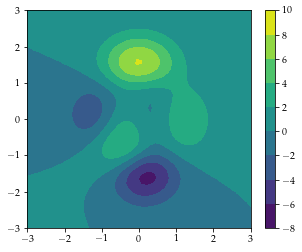

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np
from utils import peaks, plot_peaks, feas

plot_peaks()

In [2]:
from sumomo import DataHandler


n = 500    # number of samples
space = [[-3.0, 3.0],[-3.0, 3.0]]  # input space

dh = DataHandler()  # initialise DataHandler
dh.init(n, space)   # initialise input samples, x
dh.y = peaks(dh.x)  # save output samples, y
dh.t = feas(dh.x)   # save class targets, t

dh.split(test_size=0.3)  # train-test split
dh.scale()    # standardise data

In [3]:
from sumomo import NN
from torch import nn


regressor = NN([2, 10, 10, 1], 'tanh')  # build NN for regression
classifier = NN([2, 10, 1], 'tanh')     # build NN for classification

# fit regression NN to feasible scaled training data
regressor.fit(
    dh.x_train_[dh.t_train.ravel()==1, :], 
    dh.y_train_[dh.t_train.ravel()==1]
)

# fit classification NN to scaled training data using log loss
classifier.fit(
    dh.x_train_, 
    dh.t_train, 
    loss_func=nn.BCEWithLogitsLoss()
)

In [4]:
from sklearn.metrics import ( 
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score,
    log_loss
)

_, prob_test, class_test = classifier.predict(dh.x_test_, return_proba=True, return_class=True)

accuracy = accuracy_score(dh.t_test, class_test)
precision = precision_score(dh.t_test, class_test)
recall = recall_score(dh.t_test, class_test)
f1 = f1_score(dh.t_test, class_test)
bce = log_loss(dh.t_test, prob_test, eps=1e-6)

print('{:10} {:12}'.format('metric', 'value'))
print('{:10} {:<12.3f}'.format('accuracy', accuracy))
print('{:10} {:<12.3f}'.format('precision', precision))
print('{:10} {:<12.3f}'.format('recall', recall))
print('{:10} {:<12.3f}'.format('F1', f1))
print('{:10} {:<12.3f}'.format('log loss', bce))

metric     value       
accuracy   0.980       
precision  0.961       
recall     0.980       
F1         0.970       
log loss   0.059       


In [5]:
from sklearn.metrics import ( 
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error,
    median_absolute_error,
    explained_variance_score,
    r2_score,
    max_error
)

pred_test_ = regressor.predict(dh.x_test_)
pred_test = dh.inv_scale_y(pred_test_)

mae = mean_absolute_error(dh.y_test, pred_test)
mse = mean_squared_error(dh.y_test, pred_test)
mape = mean_absolute_percentage_error(dh.y_test, pred_test)
evs = explained_variance_score(dh.y_test, pred_test)
r2 = r2_score(dh.y_test, pred_test)
maxe = max_error(dh.y_test, pred_test)

mae_p1 = mean_absolute_error(dh.y_test[class_test == 1], pred_test[class_test == 1])
mse_p1 = mean_squared_error(dh.y_test[class_test == 1], pred_test[class_test == 1])
mape_p1 = mean_absolute_percentage_error(dh.y_test[class_test == 1], pred_test[class_test == 1])
evs_p1 = explained_variance_score(dh.y_test[class_test == 1], pred_test[class_test == 1])
r2_p1 = r2_score(dh.y_test[class_test == 1], pred_test[class_test == 1])
maxe_p1 = max_error(dh.y_test[class_test == 1], pred_test[class_test == 1])

mae_a1 = mean_absolute_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
mse_a1 = mean_squared_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
mape_a1 = mean_absolute_percentage_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
evs_a1 = explained_variance_score(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
r2_a1 = r2_score(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
maxe_a1 = max_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])

print('{:8} {:12} {:12} {:12}'.format('metric', 'all testing', 'predicted 1', 'actual 1'))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MAE', mae, mae_p1, mae_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MSE', mse, mse_p1, mse_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MAPE', mape, mape_p1, mape_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('EVS', evs, evs_p1, evs_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('R2', r2, r2_p1, r2_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MAXE', maxe, maxe_p1, maxe_a1))

metric   all testing  predicted 1  actual 1    
MAE      1.255        0.235        0.228       
MSE      3.992        0.109        0.099       
MAPE     451.285      0.639        0.560       
EVS      -0.297       0.982        0.985       
R2       -0.315       0.982        0.985       
MAXE     7.353        1.021        0.789       


In [6]:
import pyomo.environ as pyo


omo = pyo.ConcreteModel()    # initialise model
omo.n_inputs = set(range(len(dh.space)))  # set over input dimensions
omo.inputs = pyo.Var(omo.n_inputs, bounds=dh.space_)  # input var
omo.output = pyo.Var()  # performance output var
omo.logit = pyo.Var()   # logit output var
# feasibility constraint 
omo.feasibility_con = pyo.Constraint(
    expr=
    1 / (1 + pyo.exp(-omo.logit)) >= 0.5 
)
# objective function to maximise performance
omo.obj = pyo.Objective(expr=omo.output, sense=pyo.maximize)

omo.pprint()

1 Set Declarations
    inputs_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}

3 Var Declarations
    inputs : Size=2, Index=inputs_index
        Key : Lower               : Value : Upper              : Fixed : Stale : Domain
          0 : -1.6986969747015062 :  None : 1.8006464740895027 : False :  True :  Reals
          1 :  -1.769201965484488 :  None : 1.7487013892983287 : False :  True :  Reals
    logit : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  None :  None : False :  True :  Reals
    output : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  None :  None : False :  True :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize :     output

1 Constraint Declarations
    feasibili

In [7]:
from sumomo import BlockFormulation


# formulate pyomo blocks for regressor and classifier
omo.mdl = pyo.Block(rule=BlockFormulation(regressor).rule())
omo.feas = pyo.Block(rule=BlockFormulation(classifier).rule())

# connect pyomo model input and output to the surrogate models
omo.c = pyo.ConstraintList()
omo.c.add( omo.output == omo.mdl.outputs[0] )
omo.c.add( omo.logit == omo.feas.outputs[0] )
for i in omo.n_inputs:
    omo.c.add( omo.inputs[i] == omo.mdl.inputs[i] )
    omo.c.add( omo.inputs[i] == omo.feas.inputs[i] )

In [8]:
# solver setup
solver = pyo.SolverFactory('baron')
solver.options['MaxTime'] = 30
# macOS requires CplexLibName option to be specified, please change accordingly
solver.options['CplexLibName'] = "/Applications/CPLEX_Studio201/cplex/bin/x86-64_osx/libcplex2010.dylib"
# solve
results = solver.solve(omo, tee=True)

 BARON version 22.4.20. Built: OSX-64 Wed Apr 20 10:52:09 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value 0.985158504492     
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value  2.61905441373     
 Preprocessing found feasible solution with value  2.61905441375     
 Done with local search
  Iteration    Open 

In [9]:
# inverse scale solution
x = np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1)
solution = dh.inv_scale_x(x).ravel()

# inverse scale objective and corresponding predictions
obj = dh.inv_scale_y(np.array(omo.output.value).reshape(1, -1))
pred = dh.inv_scale_y(regressor.predict(x))

# compare optimisation outputs with model prediction
model_logit, model_proba = classifier.predict(x, return_proba=True)
omo_proba = 1 / (1 + np.exp(-omo.logit.value))

print('{:18} {:12}'.format('variable', 'value'))
print('{:18} {:<12.8f}'.format('x1*', solution[0]))
print('{:18} {:<12.8f}'.format('x2*', solution[1]))
print('{:18} {:<12.8f}'.format('omo obj at x*', obj[0][0]))
print('{:18} {:<12.8f}'.format('pred at x*', pred[0][0]))
print('{:18} {:<12.8f}'.format('omo logit', omo.logit.value))
print('{:18} {:<12.8f}'.format('logit pred at x*', model_logit.item()))
print('{:18} {:<12.8f}'.format('omo proba', omo_proba))
print('{:18} {:<12.8f}'.format('proba pred at x*', model_proba.item()))

variable           value       
x1*                0.09701514  
x2*                1.85300690  
omo obj at x*      8.11522718  
pred at x*         8.11522007  
omo logit          0.00000000  
logit pred at x*   -0.00000620 
omo proba          0.50000000  
proba pred at x*   0.49999845  


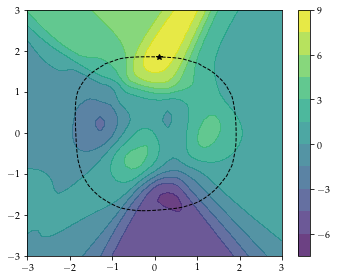

In [10]:
import matplotlib.pyplot as plt


x1, x2 = np.linspace(-3, 3, 50), np.linspace(-3, 3, 50)
x1grid, x2grid = np.meshgrid(x1, x2)
x_new = np.c_[x1grid.ravel(), x2grid.ravel()]
x_scaled = dh.scale_x(x_new)

pred = regressor.predict(x_scaled)
pred = dh.inv_scale_y(pred)
pred = pred.reshape(x1grid.shape)

prob = classifier.predict(x_scaled, return_proba=True)[1]
prob = prob.reshape(x1grid.shape)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
c = ax.contourf(x1, x2, pred, levels=12, alpha=0.8)
ax.contour(x1, x2, prob, levels=[0.5], linestyles='dashed', colors='k', linewidths=1)
ax.plot(solution[0], solution[1], 'k*')
fig.colorbar(c)

plt.tight_layout()

In [11]:
from sumomo import GPR, GPC


n = 100
space = [[-3.0, 3.0],[-3.0, 3.0]]

dh = DataHandler()
dh.init(n, space)
dh.y = peaks(dh.x)
dh.t = feas(dh.x)

dh.split(test_size=0.3)
dh.scale()

gpr = GPR()
gpc = GPC()

gpr.fit(
    dh.x_train_[dh.t_train.ravel()==1, :], 
    dh.y_train_[dh.t_train.ravel()==1]
)

gpc.fit(
    dh.x_train_, 
    dh.t_train
)

prob_test, class_test = gpc.predict(dh.x_test_, return_class=True)

accuracy = accuracy_score(dh.t_test, class_test)
precision = precision_score(dh.t_test, class_test)
recall = recall_score(dh.t_test, class_test)
f1 = f1_score(dh.t_test, class_test)
bce = log_loss(dh.t_test, prob_test)

print('{:10} {:12}'.format('metric', 'value'))
print('{:10} {:<12.3f}'.format('accuracy', accuracy))
print('{:10} {:<12.3f}'.format('precision', precision))
print('{:10} {:<12.3f}'.format('recall', recall))
print('{:10} {:<12.3f}'.format('F1', f1))
print('{:10} {:<12.3f}'.format('log loss', bce))

/Users/alexdurkin/miniconda3/envs/sumomo-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


metric     value       
accuracy   0.967       
precision  0.909       
recall     1.000       
F1         0.952       
log loss   0.235       


In [12]:
pred_test = gpr.predict(dh.x_test_)

mae = mean_absolute_error(dh.y_test, pred_test)
mse = mean_squared_error(dh.y_test, pred_test)
mape = mean_absolute_percentage_error(dh.y_test, pred_test)
evs = explained_variance_score(dh.y_test, pred_test)
r2 = r2_score(dh.y_test, pred_test)
maxe = max_error(dh.y_test, pred_test)

mae_p1 = mean_absolute_error(dh.y_test[class_test == 1], pred_test[class_test == 1])
mse_p1 = mean_squared_error(dh.y_test[class_test == 1], pred_test[class_test == 1])
mape_p1 = mean_absolute_percentage_error(dh.y_test[class_test == 1], pred_test[class_test == 1])
evs_p1 = explained_variance_score(dh.y_test[class_test == 1], pred_test[class_test == 1])
r2_p1 = r2_score(dh.y_test[class_test == 1], pred_test[class_test == 1])
maxe_p1 = max_error(dh.y_test[class_test == 1], pred_test[class_test == 1])

mae_a1 = mean_absolute_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
mse_a1 = mean_squared_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
mape_a1 = mean_absolute_percentage_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
evs_a1 = explained_variance_score(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
r2_a1 = r2_score(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
maxe_a1 = max_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])

print('{:8} {:12} {:12} {:12}'.format('metric', 'all testing', 'predicted 1', 'actual 1'))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MAE', mae, mae_p1, mae_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MSE', mse, mse_p1, mse_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MAPE', mape, mape_p1, mape_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('EVS', evs, evs_p1, evs_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('R2', r2, r2_p1, r2_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MAXE', maxe, maxe_p1, maxe_a1))

metric   all testing  predicted 1  actual 1    
MAE      0.947        2.150        2.263       
MSE      2.452        6.388        6.921       
MAPE     0.929        0.856        0.853       
EVS      0.427        0.449        0.449       
R2       0.332        0.231        0.241       
MAXE     4.798        4.798        4.798       


In [13]:
# larger optimisation formulation
omo = pyo.ConcreteModel()
omo.n_inputs = set(range(len(dh.space)))
omo.inputs = pyo.Var(omo.n_inputs, bounds=dh.space_)
omo.output = pyo.Var()
omo.proba = pyo.Var()
omo.feasibility_con = pyo.Constraint(expr= omo.proba >= 0.5 )
omo.obj = pyo.Objective(expr=omo.output, sense=pyo.maximize)

# formulate pyomo blocks for gpr and gpc
omo.mdl = pyo.Block(rule=BlockFormulation(gpr).rule())
omo.feas = pyo.Block(rule=BlockFormulation(gpc).rule())

# connect pyomo model input and output to the surrogate models
omo.c = pyo.ConstraintList()
for i in omo.n_inputs:
    omo.c.add( omo.inputs[i] == omo.mdl.inputs[i] )
    omo.c.add( omo.inputs[i] == omo.feas.inputs[i] )
omo.c.add( omo.output == omo.mdl.outputs[0] )
omo.c.add( omo.proba == omo.feas.outputs[0] )

In [14]:
# solver setup
solver = pyo.SolverFactory('baron')
solver.options['MaxTime'] = 30
# macOS requires CplexLibName option to be specified, please change accordingly
solver.options['CplexLibName'] = "/Applications/CPLEX_Studio201/cplex/bin/x86-64_osx/libcplex2010.dylib"
# solve
results = solver.solve(omo, tee=True)

# inverse scale solution
x = np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1)
solution = dh.inv_scale_x(x).ravel()

# inverse scale objective and corresponding predictions
obj = dh.inv_scale_y(np.array(omo.output.value).reshape(1, -1))
pred = dh.inv_scale_y(gpr.predict(x.reshape(1, -1)))

# compare optimisation outputs with model prediction
print()
print('{:18} {:12}'.format('variable', 'value'))
print('{:18} {:<12.8f}'.format('x1*', solution[0]))
print('{:18} {:<12.8f}'.format('x2*', solution[1]))
print('{:18} {:<12.8f}'.format('omo obj at x*', obj[0][0]))
print('{:18} {:<12.8f}'.format('pred at x*', pred[0][0]))
print('{:18} {:<12.8f}'.format('omo proba', omo.proba.value))
print('{:18} {:<12.8f}'.format('proba pred at x*', gpc.predict(x.reshape(1, -1)).item()))

 BARON version 22.4.20. Built: OSX-64 Wed Apr 20 10:52:09 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value 0.896606057607     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1             1             2.18     0.896606         24.6856    
*        

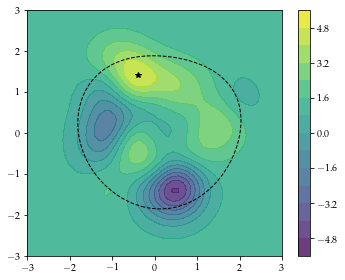

In [16]:
import matplotlib.pyplot as plt


x1, x2 = np.linspace(-3, 3, 50), np.linspace(-3, 3, 50)
x1grid, x2grid = np.meshgrid(x1, x2)
x_new = np.c_[x1grid.ravel(), x2grid.ravel()]
x_scaled = dh.scale_x(x_new)

pred = gpr.predict(x_scaled)
pred = dh.inv_scale_y(pred)
pred = pred.reshape(x1grid.shape)

prob = gpc.predict(x_scaled)
prob = prob.reshape(x1grid.shape)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
c = ax.contourf(x1, x2, pred, levels=12, alpha=0.8)
ax.contour(x1, x2, prob, levels=[0.5], linestyles='dashed', colors='k', linewidths=1)
ax.plot(solution[0], solution[1], 'k*')
fig.colorbar(c)

plt.tight_layout()